# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In [1]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# First Party
from notebooks.hfdemo.tinytimemixer.utils import (  # find_lr,
    TrackingCallback,
    count_parameters,
    get_data,
    get_ttm_args,
    plot_preds,
)

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction

2024-04-06 10:46:27.624321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

## Zero-shot evaluation method

In [3]:
def zeroshot_eval(
    dataset_name, 
    batch_size,
    context_length=512,
    forecast_length=96,
):
    # Get data
    _, _, dset_test = get_data(dataset_name=dataset_name, context_length=context_length, forecast_length=forecast_length, fewshot_fraction=1.0)
    
    # Load model
    zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
        "ibm/TTM", revision="main"
    )
    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
        )
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

 ## Few-shot finetune and evaluation method

In [4]:
def fewshot_finetune_eval(
        dataset_name, 
        batch_size, 
        learning_rate=0.001,
        context_length=512,
        forecast_length=96,
        fewshot_percent=5, 
        freeze_backbone=True,
        num_epochs=50,
        save_dir="ttm_finetuned_models/"
    ):
    
    out_dir = os.path.join(save_dir, dataset_name)
    
    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)
    
    # Data prep: Get dataset
    dset_train, dset_val, dset_test = get_data(
        dataset_name,
        context_length,
        forecast_length,
        fewshot_fraction=fewshot_percent / 100,
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm/TTM", revision="main", head_dropout=0.7
        )
    else:
        finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm/TTM", revision="main",
        )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=out_dir,
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to=None,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=out_dir,  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)
    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

## Example 1: Target dataset - ettm1

In [5]:
target_dataset = "ettm1"

### Zero-shot

In [6]:
zeroshot_eval(dataset_name=target_dataset, batch_size=64)

ettm1 512 96
Data lengths: train = 33953, val = 11425, test = 11425
++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.41525667905807495, 'eval_runtime': 3.0673, 'eval_samples_per_second': 3724.77, 'eval_steps_per_second': 58.357}


### Few-shot 5%

In [7]:
fewshot_finetune_eval(dataset_name=target_dataset, batch_size=64)

-------------------- Running few-shot 5% --------------------
ettm1 512 96
Data lengths: train = 1607, val = 11425, test = 11425
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.610900,0.462954
2,0.500200,0.465854
3,0.436900,0.474582
4,0.355300,0.482520
5,0.305400,0.476272
6,0.262900,0.462355
7,0.249700,0.456231
8,0.243300,0.455198
9,0.230800,0.449544
10,0.227700,0.457483


[TrackingCallback] Mean Epoch Time = 1.0508287078455876 seconds, Total Train Time = 54.32607340812683
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.3655141294002533, 'eval_runtime': 1.5512, 'eval_samples_per_second': 7365.066, 'eval_steps_per_second': 115.391, 'epoch': 19.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


## Example 2: Target dataset - M4

In [8]:
from notebooks.hfdemo.tinytimemixer.m4_dataloader.datautils import get_m4_dataloaders
from notebooks.hfdemo.tinytimemixer.utils import m4_test, m4_finetune

In [9]:
m4_forecast_length = 48

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [10]:
train_data, train_loader, test_data, test_loader = get_m4_dataloaders(dataset_name="m4_hourly", context_length=512, forecast_length=48)

train 414
test 414


### Zero-shot on M4

In [11]:
# Load model
model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm/TTM", revision="main", prediction_filter_length=m4_forecast_length
).to(device)

0
test shape: (414, 48, 1)
==================== M4 Evaluation Metric ====================
Data = Hourly, MSE = 1733120.3053451509
Data = Hourly, Naive2 MSE = 3187913.2677412867

Data = Hourly, MAE = 274.3367973821735
Data = Hourly, Naive2 MAE = 366.7593400292926

Data = Hourly, MAPE = 0.15467017058418878 (not %)
Data = Hourly, Naive2 MAPE = 0.22019547019161032 (not %)

Data = Hourly, MASE = 2.2843113045033974
Data = Hourly, Naive2 MASE = 2.3950400131234

Data = Hourly, sMAPE = 0.06439063592603193 (not %)
Data = Hourly, Naive2 sMAPE = 0.09191439057157862 (not %)

Data = Hourly, OWA = 0.8271587978543737 (should be <1 to be better than naive)


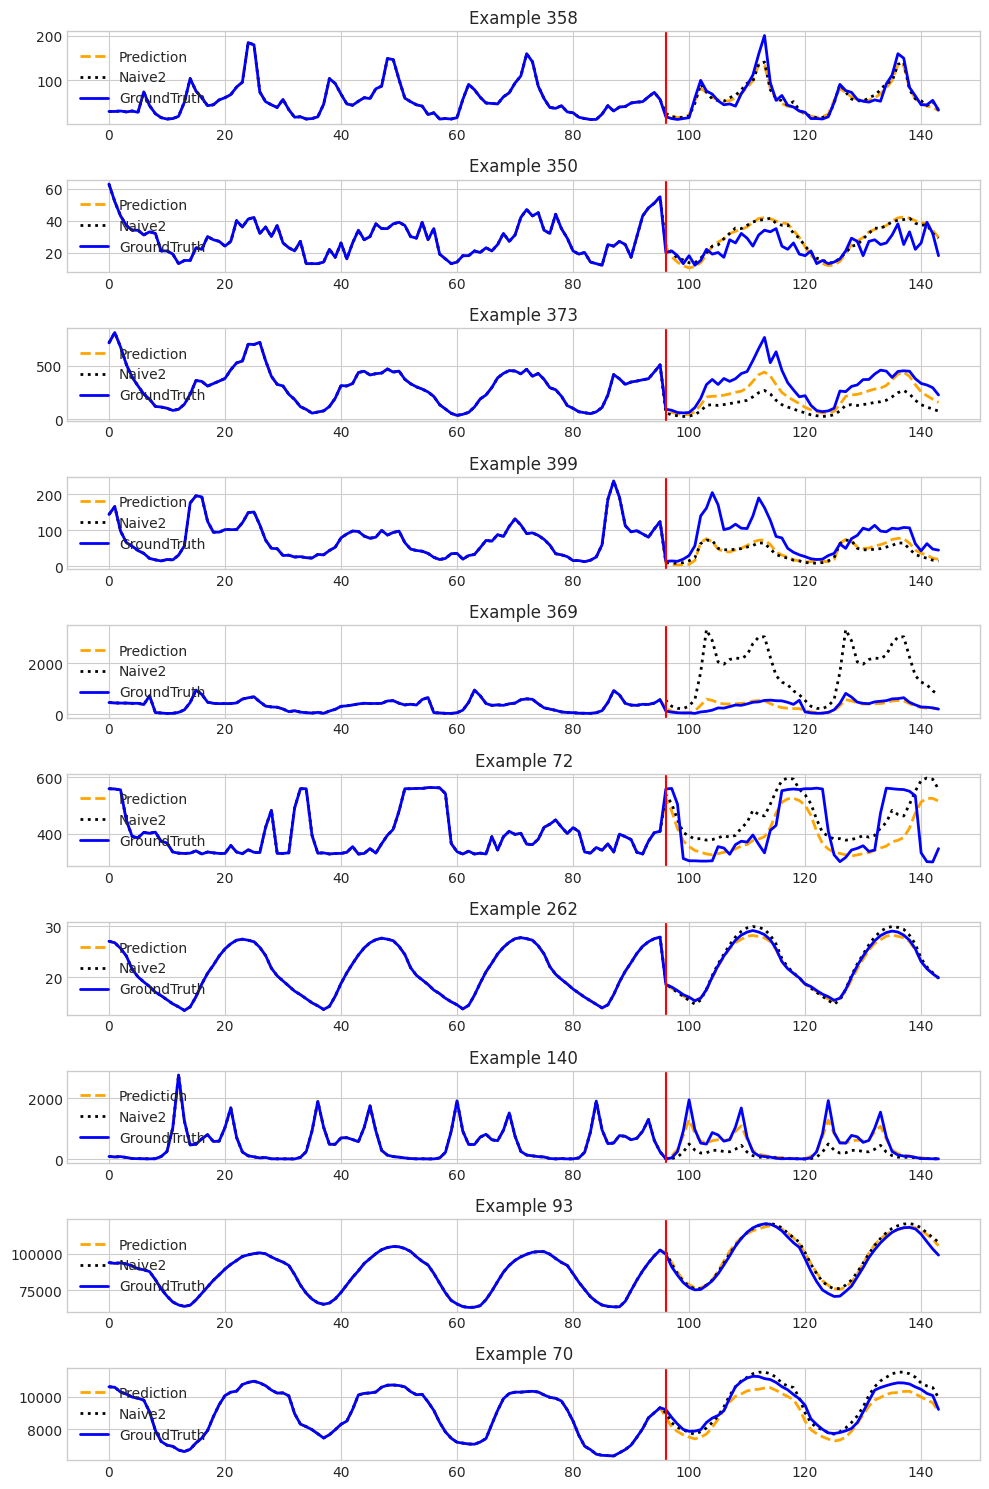

In [12]:
m4_test(
    model,
    train_loader,
    test_loader,
    "ttm_finetuned_models/m4_hourly",
    "zeroshot",
    device,
)

### Fine-tune on M4 data

In [13]:
model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm/TTM",
            revision="main",
            prediction_filter_length=m4_forecast_length,
            head_dropout=0.0,
            dropout=0.0,
            loss="mae",
        ).to("cuda")

In [14]:
m4_finetune(model, train_data, save_path="ttm_finetuned_models/m4_hourly/finetune")

Step,Training Loss
7,0.317900
14,0.306100
21,0.301200
28,0.305000
35,0.280600
42,0.292200
49,0.280000
56,0.261500
63,0.268100
70,0.259900


In [15]:
# Load model
model = TinyTimeMixerForPrediction.from_pretrained("ttm_finetuned_models/m4_hourly/finetune/ttm_pretrained/").to(device)

0
test shape: (414, 48, 1)
==================== M4 Evaluation Metric ====================
Data = Hourly, MSE = 1198434.4627046108
Data = Hourly, Naive2 MSE = 3187913.2677412867

Data = Hourly, MAE = 263.3856101236876
Data = Hourly, Naive2 MAE = 366.7593400292926

Data = Hourly, MAPE = 0.1512775502208849 (not %)
Data = Hourly, Naive2 MAPE = 0.22019547019161032 (not %)

Data = Hourly, MASE = 1.132952450945958
Data = Hourly, Naive2 MASE = 2.3950400131234

Data = Hourly, sMAPE = 0.06367454022312544 (not %)
Data = Hourly, Naive2 sMAPE = 0.09191439057157862 (not %)

Data = Hourly, OWA = 0.5829001714451879 (should be <1 to be better than naive)


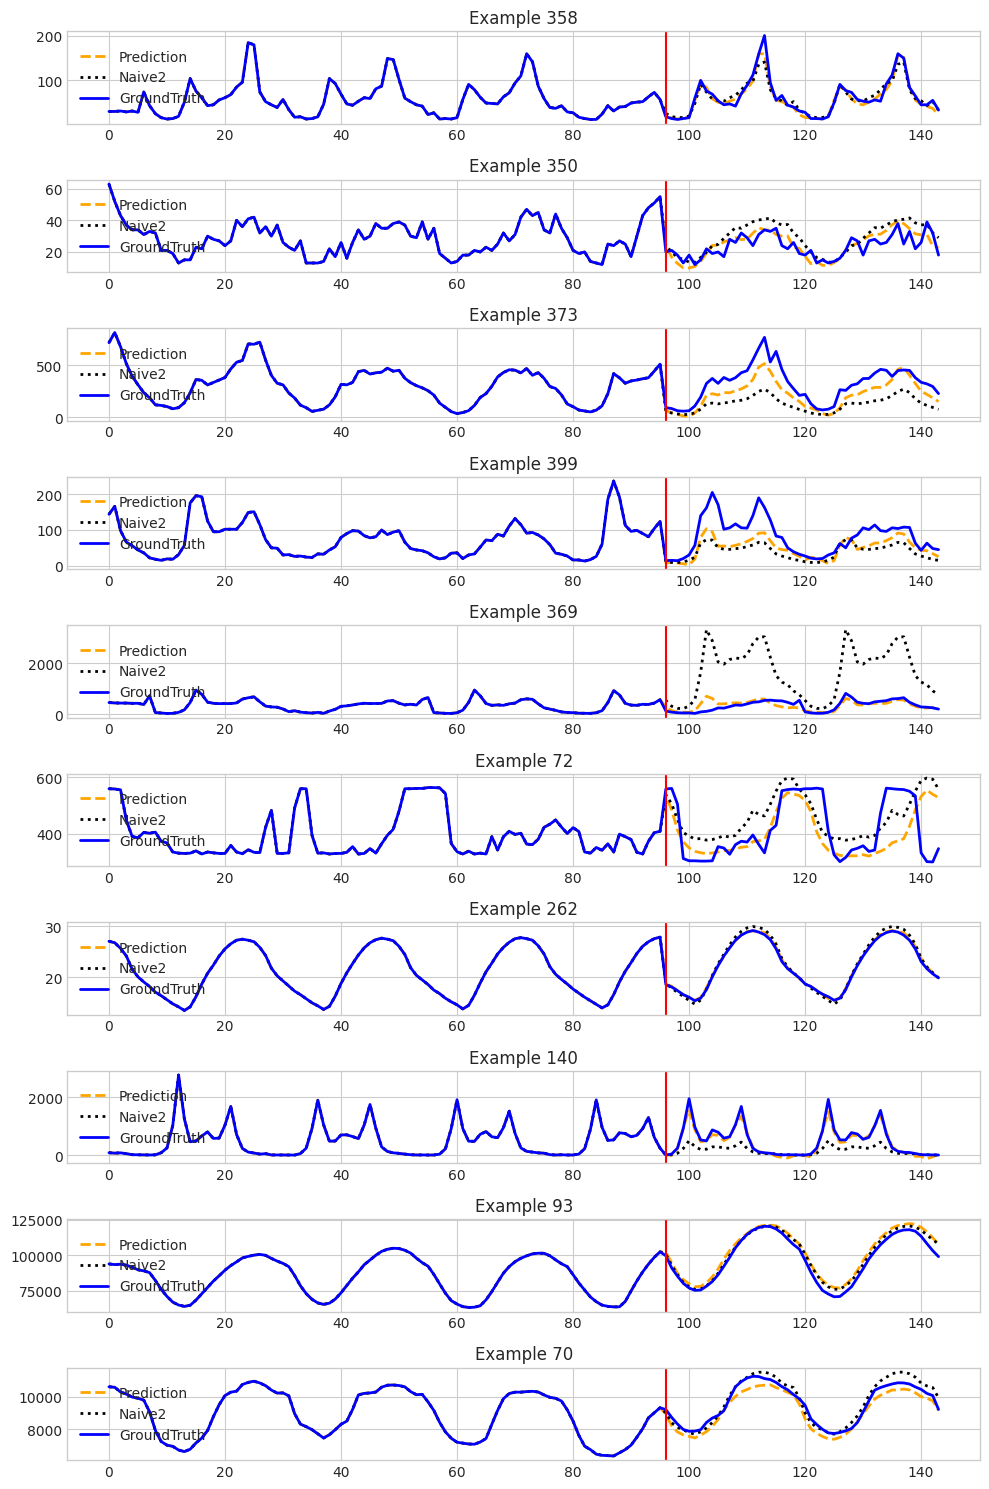

In [16]:
m4_test(
    model,
    train_loader,
    test_loader,
    "ttm_finetuned_models/m4_hourly",
    "finetune",
    device,
)